# **Computational Tools for Data Science**

## Group 4
- Ævarsson, Brynjar Karl
- Eiríksdóttir, Málfríður Anna
- Ingvarsdóttir, Védís Sigríður
- Matthíasdóttir, Jónína
- Sturluson, Birkir Fanndal

## Table of Contents
1. [Preprocessing of the data](#Read-in-preprocessed-data)
2. [Plot analysis](#Plot-analysis)
3. [Frequent Items: A-Priori Algorithm](#frequent-items-a-priori-agorithm)
4. [Clustering](#Clustering) 
    1. [Kmeans](#K-means)
    2. [Metrics: David-Bouldin Index](#metrics-davies-bouldin-index)
5. [Feature Engineering](#Feature-Engineering)
6. [Supervised Machine Learning](#Supervised-Machine-Learning)
    1. [Logistic Regression](#Logistic-Regression)
    2. [Random Forest](#Random-Forest)
    3. [PCA for Dimensionality Reduction](#pca-for-dimensionality-reduction)
    4. [Gradient Boosting](#gradient-boosting)
    5. [Model Comparison](#overall-model-comparison)
    6. [Conclusion](#final-conclusions)
7. [Contributions](#contributions)


## Imports

In [30]:
import pandas as pd
import numpy as np
import re
import json
import ast
import logging
from datetime import datetime
from collections import Counter
import pickle
import string  

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.cm as cm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import contractions

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.preprocessing import TransactionEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay,
    pairwise as cosine_similarity
)

from mlxtend.frequent_patterns import apriori, association_rules

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.quality import modularity

from datasketch import MinHash, MinHashLSH

from lightgbm import LGBMClassifier


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Read in preprocessed data**

- Load a CSV file into a df and clean column names and values.
- Preprocesse text data by cleaning, removing stopwords, and lemmatizing.
- Process tokenized text into a usable format for feature extraction.
- Extract important text features using TF-IDF vectorization.
- Add additional features.
- One-hot encode the category column to create binary features.
- Combine all features into a single dataset for analysis.
- Standardize the features and reduces their dimensionality using PCA.


In [31]:
data = pd.read_csv('../data/fake_reviews_dataset.csv')
data.rename(columns={'text_': 'text'}, inplace=True)
data['category'] = data['category'].str.replace('_5', '', regex=False)

def preprocess_text(text):

    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

data['processed_text'] = data['text'].apply(preprocess_text)

data['processed_text_str'] = data['processed_text'].str.join(' ')

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_df = pd.DataFrame(
    tfidf.fit_transform(data['processed_text_str']).toarray(),
    columns=tfidf.get_feature_names_out(),
    index=data.index
)

data['text_length'] = data['processed_text_str'].str.len()
data['unique_word_ratio'] = data['processed_text'].apply(
    lambda tokens: len(set(tokens)) / len(tokens) if tokens else 0
)

categories = pd.get_dummies(data['category'], prefix='category')

features = pd.concat([
    tfidf_df,
    data[['text_length', 'unique_word_ratio', 'rating']].reset_index(drop=True),
    categories.reset_index(drop=True)
], axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=0.95, random_state=42)
pca_features = pca.fit_transform(scaled_features)

print(f'Original number of features: {scaled_features.shape[1]}')
print(f'Reduced number of features after PCA: {pca_features.shape[1]}')


Original number of features: 1013
Reduced number of features after PCA: 918


## **Plot analysis**

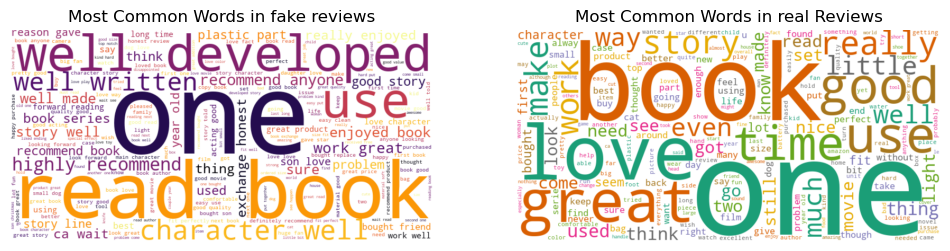

In [32]:
cg_text = ' '.join([' '.join(words) for words in data[data['label'] == 'CG']['processed_text']])
or_text = ' '.join([' '.join(words) for words in data[data['label'] == 'OR']['processed_text']])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cg_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(cg_text)
plt.imshow(cg_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in fake reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
or_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(or_text)
plt.imshow(or_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in real Reviews')
plt.axis('off')

plt.show()

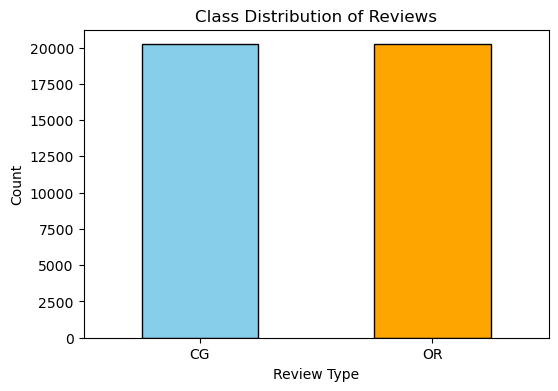

In [33]:
plt.figure(figsize=(6, 4))
data['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')
plt.title("Class Distribution of Reviews")
plt.xlabel("Review Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

We can see from this figure that the dataset has about 50% CG reviews and 50% OR reviews. This is good as it gives us more data to possibly identify more easily.

## **Frequent Items: A-Priori Agorithm**

- Split data into real and fake reviews.
- Generating baskets for both real and fake textual data.
- Encoding real reviews and then applying the apriori algorithm to generate frequent itemsets.
- Deriving association rules for the real review dataset.
- Encoding fake reviews and then applying the apriori algorithm to generate frequent itemsets.
- Deriving association rules for the fake review dataset.
- Test different values of minimum support threshold against the number of frequent itemsets.
- Plotting the distributions of support values for both real and fake reviews.

In [34]:
# splitting data into real and fake reviews
real_reviews_df = data[data['label'] == "OR"]  
fake_reviews_df = data[data['label'] == "CG"]  

# creating baskets for both real and fake review text data
real_baskets = real_reviews_df['processed_text'].tolist()
fake_baskets = fake_reviews_df['processed_text'].tolist()

In [35]:
# encoding real reviews
te = TransactionEncoder()
real_encoded = te.fit(real_baskets).transform(real_baskets)
real_df = pd.DataFrame(real_encoded, columns=te.columns_)

# frequent itemsets for real reviews
real_itemsets = apriori(real_df, min_support=0.05, use_colnames=True)
num_itemsets_real=len(real_itemsets)

# association rules for real reviews
real_rules = association_rules(real_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=num_itemsets_real)

In [36]:
# encoding fake reviews
te = TransactionEncoder()
fake_encoded = te.fit(fake_baskets).transform(fake_baskets)
fake_df = pd.DataFrame(fake_encoded, columns=te.columns_)

# frequent itemsets for real reviews
fake_itemsets = apriori(fake_df, min_support=0.05, use_colnames=True)
num_itemsets_fake = len(fake_itemsets)

# association rules for real reviews
fake_rules = association_rules(fake_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=num_itemsets_fake)

In [37]:
thresholds = [0.02, 0.03, 0.05, 0.07]
for threshold in thresholds:
    fake_itemsets = apriori(fake_df, min_support=threshold, use_colnames=True)
    real_itemsets = apriori(real_df, min_support=threshold, use_colnames=True)
    print(f"Threshold: {threshold}")
    print(f"Number of fake itemsets: {len(fake_itemsets)}, Number of real itemsets: {len(real_itemsets)}")

Threshold: 0.02
Number of fake itemsets: 2588, Number of real itemsets: 690
Threshold: 0.03
Number of fake itemsets: 794, Number of real itemsets: 273
Threshold: 0.05
Number of fake itemsets: 196, Number of real itemsets: 97
Threshold: 0.07
Number of fake itemsets: 82, Number of real itemsets: 48


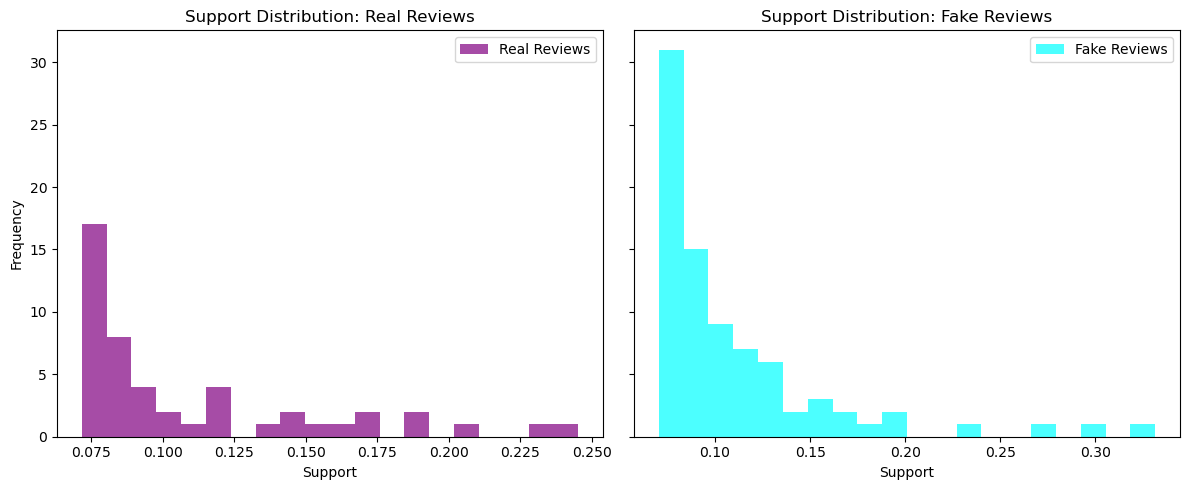

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(real_itemsets['support'], bins=20, color='purple', alpha=0.7, label='Real Reviews')
axes[0].set_title('Support Distribution: Real Reviews')
axes[0].set_xlabel('Support')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(fake_itemsets['support'], bins=20, color='cyan', alpha=0.7, label='Fake Reviews')
axes[1].set_title('Support Distribution: Fake Reviews')
axes[1].set_xlabel('Support')
axes[1].legend()

plt.tight_layout()
plt.show()


The results of this analysis shows that the diversity in the real reviews is much more than in the fake ones, as the fake reviews have a higher number of frequent itemsets. This makes sense as computer generated reviews often include more repititions.

## **Clustering**

- Generate a range of cluster numbers (k) from 2 to 10 for K-Means clustering.
- Iterate through each value of k to perform K-Means clustering on PCA-transformed features.
- Assign cluster labels to the data and calculate the Davies-Bouldin Index for each clustering.
- Display a contingency table showing the relationship between cluster labels and true labels.
- Perform a second PCA to reduce features to 2 dimensions for visualization.
- Create scatter plots of the clusters with different colors and shapes to represent cluster and label differences.
- Store the results (k, Davies-Bouldin Index, and contingency table) in a list.

### K means

Preforming clustering for k = 2: 
Davies-Bouldin Index: 11.0623
Contingency Table:
label       CG     OR
cluster              
0         5997   5706
1        14219  14510


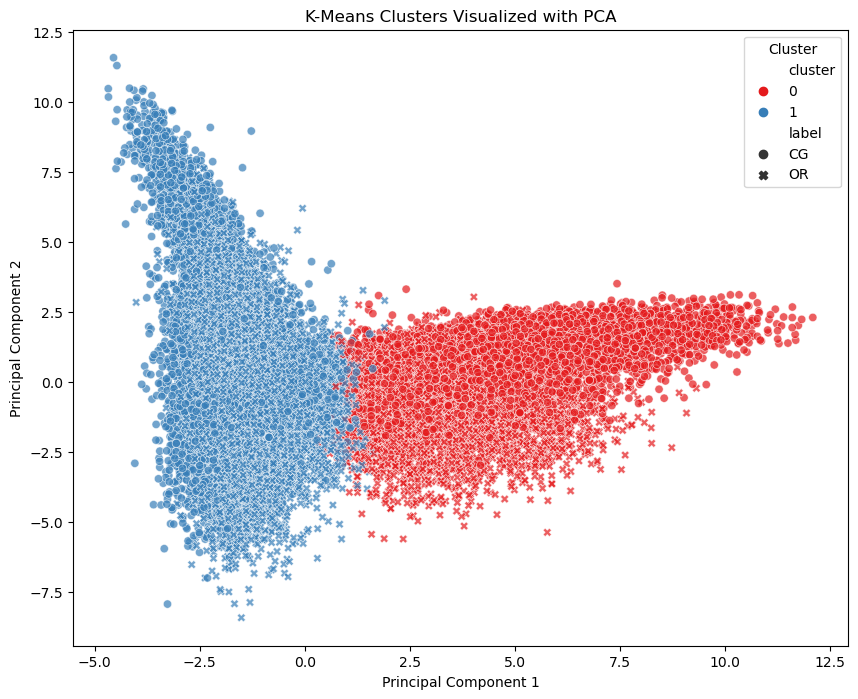

Preforming clustering for k = 3: 
Davies-Bouldin Index: 8.8725
Contingency Table:
label       CG     OR
cluster              
0         5991   5693
1        14133  14397
2           92    126


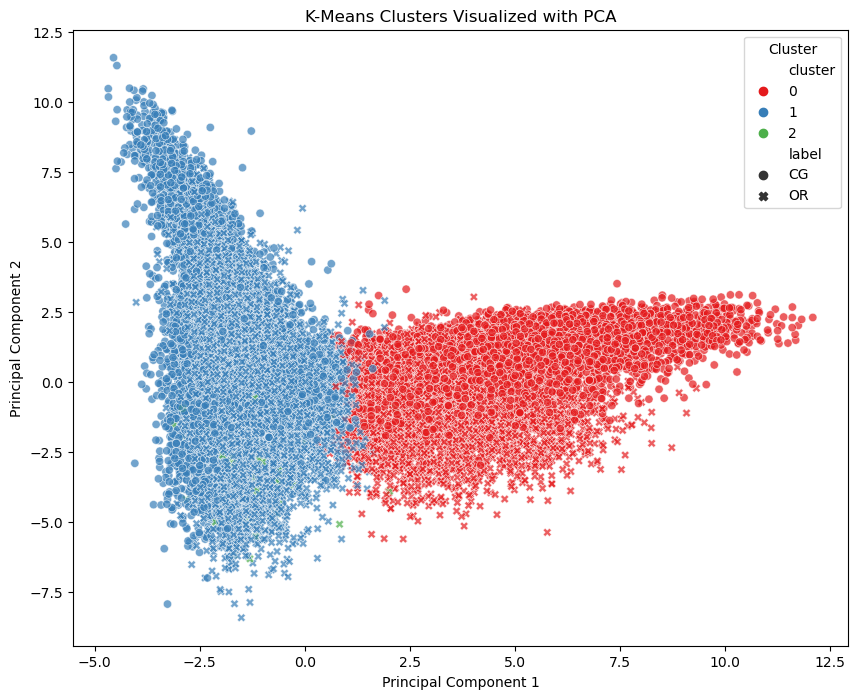

Preforming clustering for k = 4: 
Davies-Bouldin Index: 7.4827
Contingency Table:
label       CG     OR
cluster              
0         5992   5688
1        14054  14325
2           92    126
3           78     77


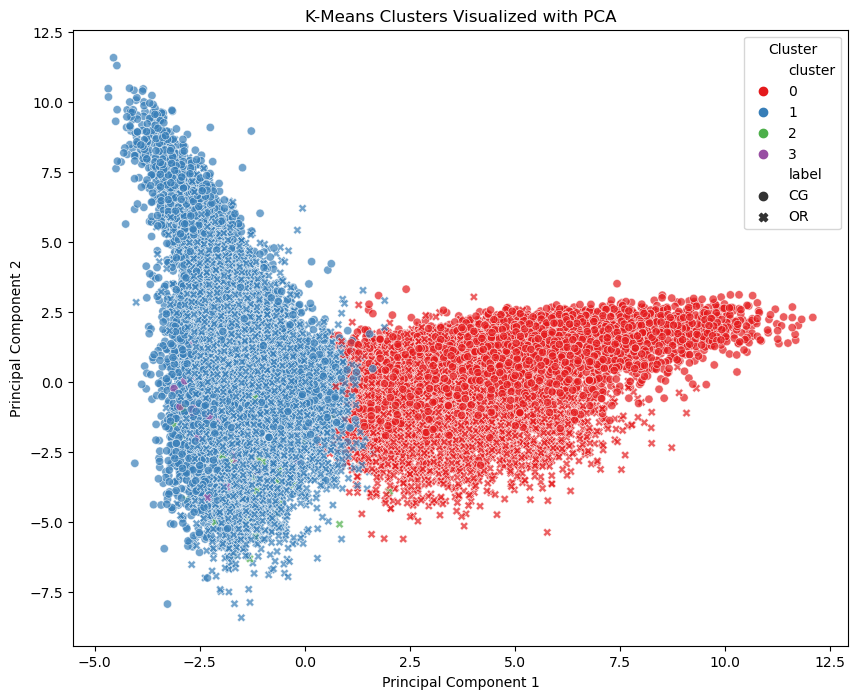

Preforming clustering for k = 5: 
Davies-Bouldin Index: 7.2833
Contingency Table:
label       CG     OR
cluster              
0         1713   1629
1         4383   4186
2           92    125
3           78     77
4        13950  14199


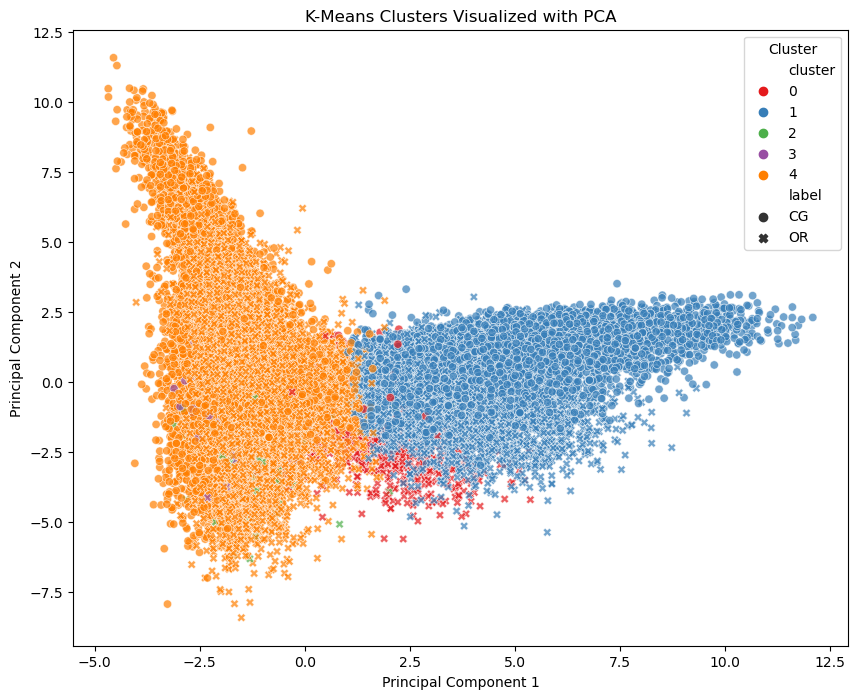

Preforming clustering for k = 6: 
Davies-Bouldin Index: 8.0313
Contingency Table:
label       CG     OR
cluster              
0         1713   1631
1         4383   4208
2           87    114
3           78     77
4        12238  12350
5         1717   1836


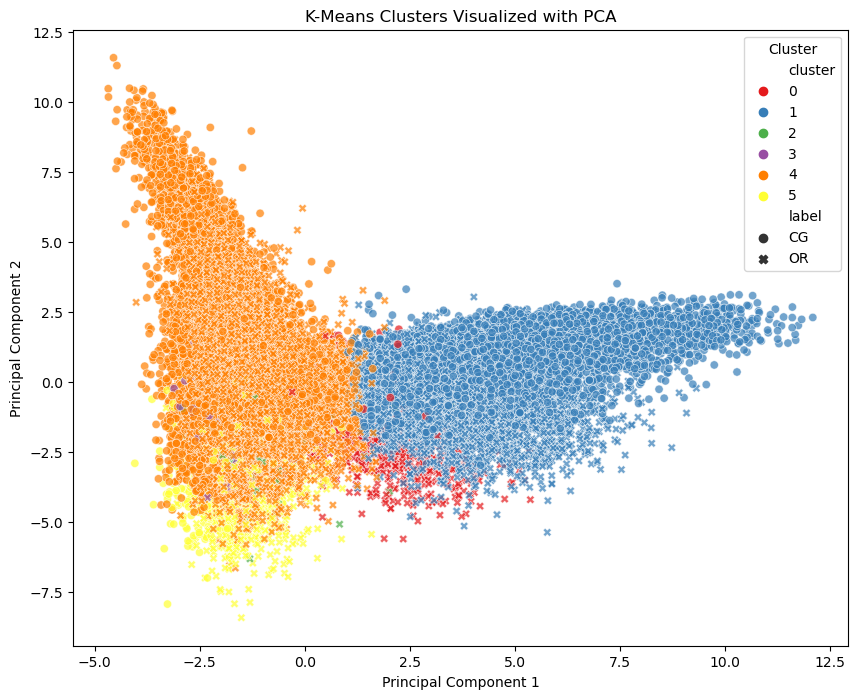

Preforming clustering for k = 7: 
Davies-Bouldin Index: 7.4460
Contingency Table:
label       CG     OR
cluster              
0         1711   1631
1         4383   4200
2           87    114
3           78     77
4        12146  12315
5         1695   1817
6          116     62


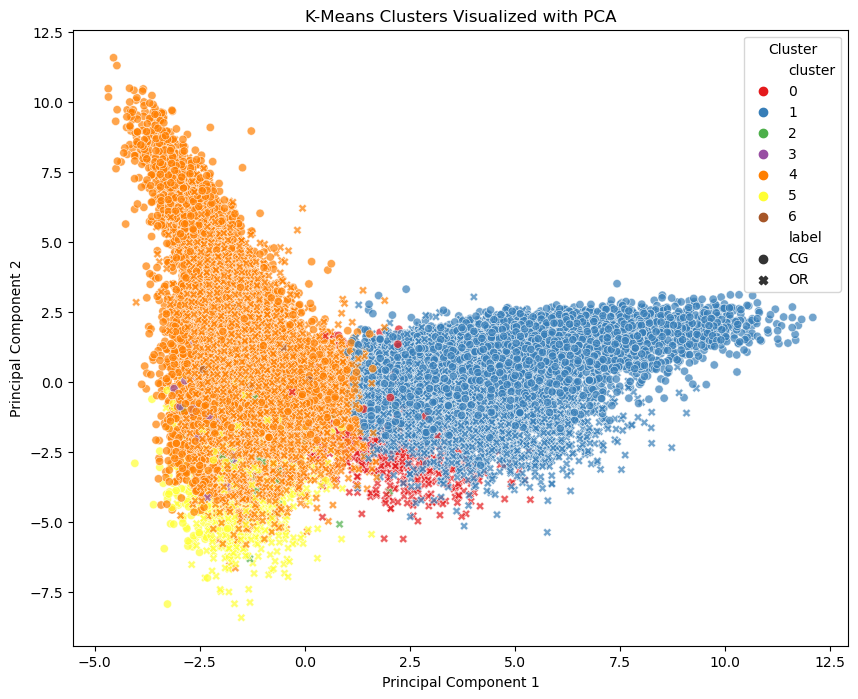

Preforming clustering for k = 8: 
Davies-Bouldin Index: 5.5905
Contingency Table:
label       CG     OR
cluster              
0         1708   1616
1         4306   4099
2           79     83
3        13911  14209
4           43     61
5           34     96
6           55     25
7           80     27


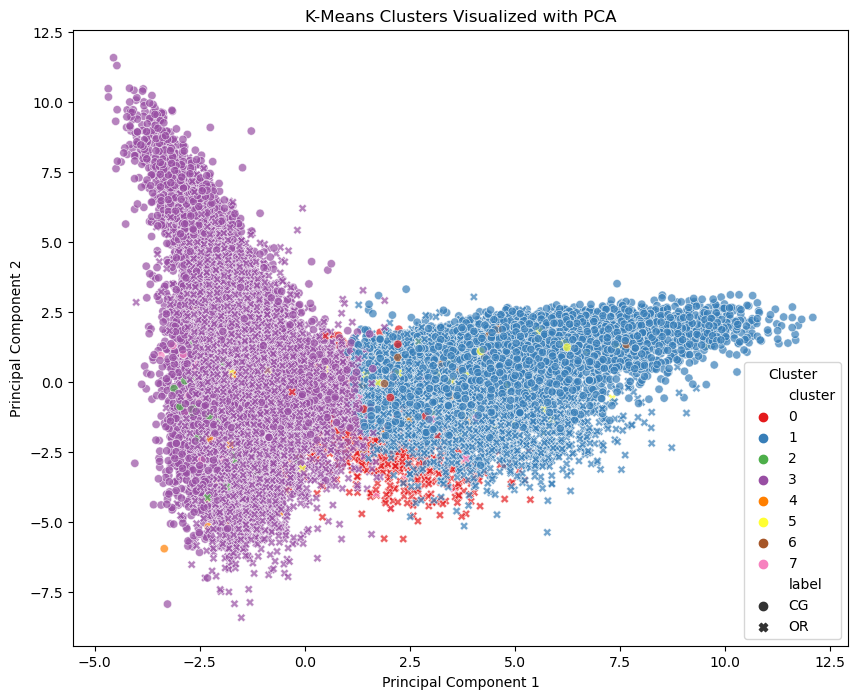

Preforming clustering for k = 9: 
Davies-Bouldin Index: 5.5763
Contingency Table:
label       CG     OR
cluster              
0         1706   1616
1         4301   4091
2           79     83
3        13703  13998
4           43     61
5           34     95
6           55     25
7           78     27
8          217    220


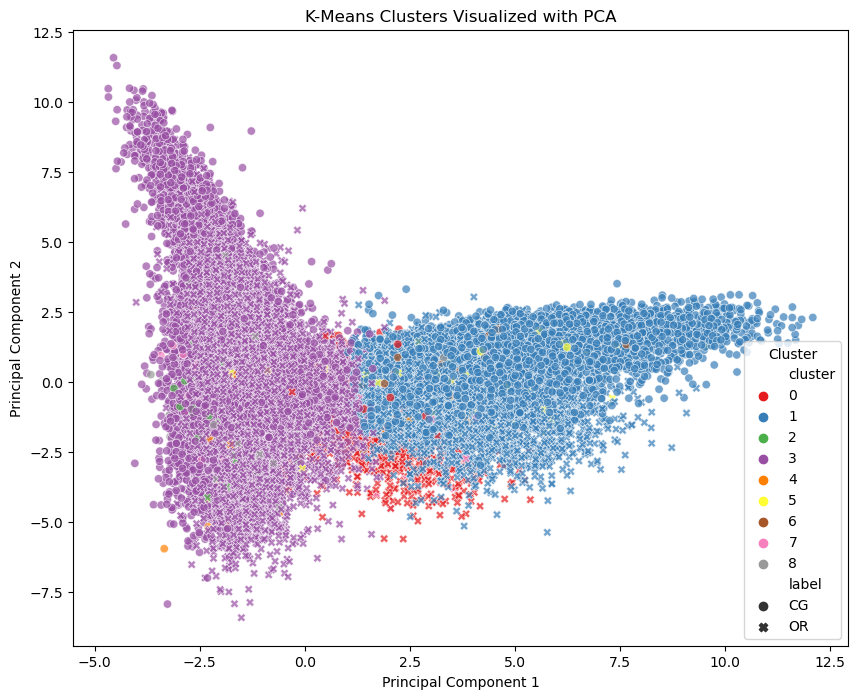

Preforming clustering for k = 10: 
Davies-Bouldin Index: 5.4815
Contingency Table:
label       CG     OR
cluster              
0         1706   1612
1         4294   4075
2           79     83
3        13612  13881
4           43     61
5           34     95
6           55     25
7           78     27
8          215    220
9          100    137


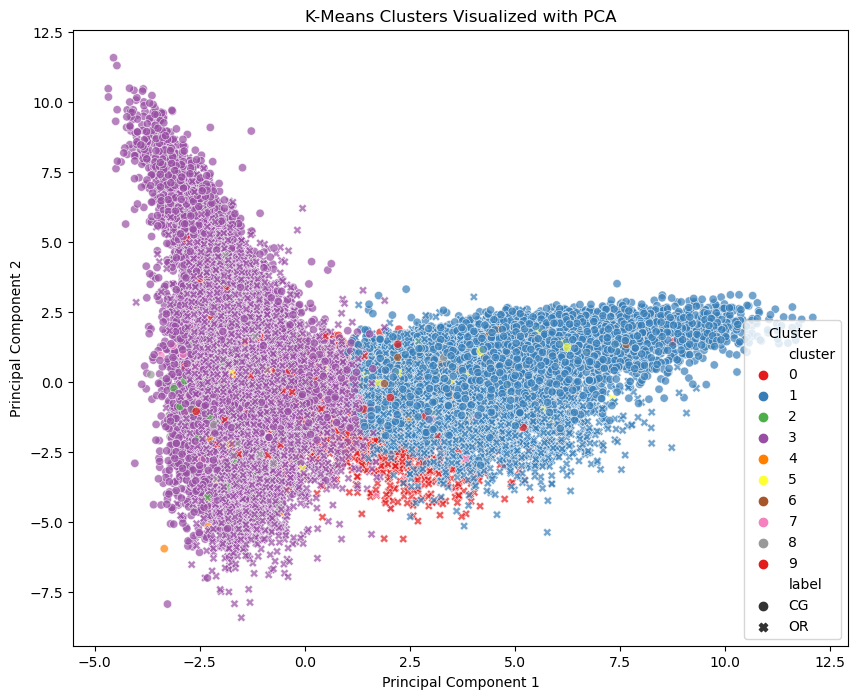

In [39]:
ks = np.linspace(2,10,9)
db_scores = []
results = []
for k in ks:

    k = int(k)
    print(f'Preforming clustering for k = {k}: ')
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_features)

    data['cluster'] = cluster_labels

    davies_bouldin = davies_bouldin_score(pca_features, cluster_labels)
    print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')
    db_scores.append(davies_bouldin)
    contingency_table = pd.crosstab(data['cluster'], data['label'])
    print('Contingency Table:')
    print(contingency_table)


    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(pca_features)
    data['pc1'] = principal_components[:, 0]
    data['pc2'] = principal_components[:, 1]


    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='pc1', y='pc2',
        hue='cluster',
        style='label',  
        palette='Set1',
        data=data,
        alpha=0.7
    )
    plt.title('K-Means Clusters Visualized with PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()

    results.append({
        'k': k,
        'davies_bouldin_index': davies_bouldin,
        'contingency_table': contingency_table.to_string()
    })

results_df = pd.DataFrame(results)
results_df.to_csv('clustering_results.csv', index=False)

### **Plotting**

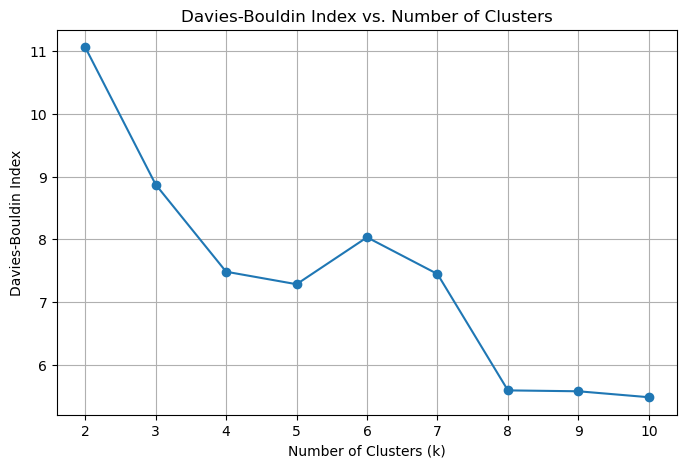

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(ks, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.savefig('davies_bouldin_vs_k.png')
plt.show()

### **Metrics: Davies-Bouldin Index**

In [41]:
metrics_df = pd.DataFrame({
    'Number of Clusters (k)': ks,
    'Davies-Bouldin Index': db_scores
})

metrics_df.to_csv('evaluation_metrics.csv', index=False)

print(metrics_df)

   Number of Clusters (k)  Davies-Bouldin Index
0                     2.0             11.062280
1                     3.0              8.872534
2                     4.0              7.482674
3                     5.0              7.283266
4                     6.0              8.031303
5                     7.0              7.446000
6                     8.0              5.590454
7                     9.0              5.576283
8                    10.0              5.481498


## **Feature Engineering**

The code below uses TF-IDF Vectorization to transform the processed_text_str into a numerical format that will be suitable for machine learning models. TF-IDF (Term Frequency-Inverse Document Frequency) quantifies the importance of words in a document relative to a collection of documents. Here each row represents a document, and each column represents a word from the vocabulary, and each value is the TF-IDS score of that given document. 

In [42]:
tfidf_features = tfidf.fit_transform(data['processed_text_str'])

tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())



The code below calculates the text length (the number of characters in each review) and the unique word ratio (the proportion of unique words to total words in each review). Then these new features are combined with the previously generated TF-IDF features. Next we use the category column and convert each unique category into a seperate binary feature. These one-hot encoded feature are then added to the feature set. 

In [43]:
data['text_length'] = data['text'].apply(len)

data['unique_word_ratio'] = data['processed_text'].apply(lambda tokens: len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0)

features = pd.concat([tfidf_df, data[['text_length', 'unique_word_ratio', 'rating']]], axis=1)

categories = pd.get_dummies(data['category'], prefix='category')

features = pd.concat([features, categories], axis=1)



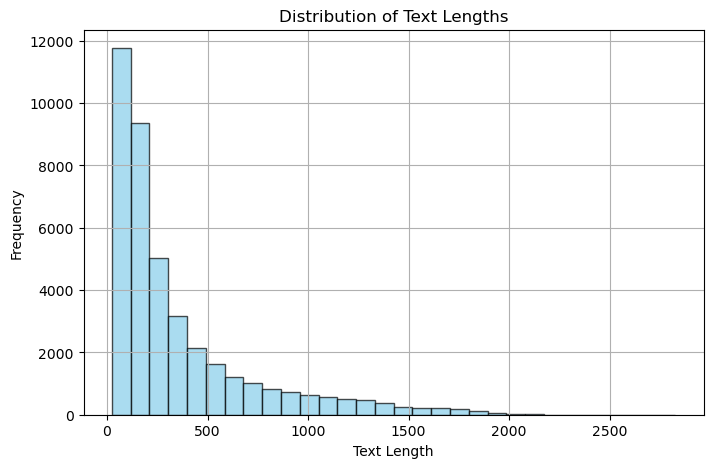

In [44]:
# Text Length Distribution
plt.figure(figsize=(8, 5))
plt.hist(data['text_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.grid()
plt.show()


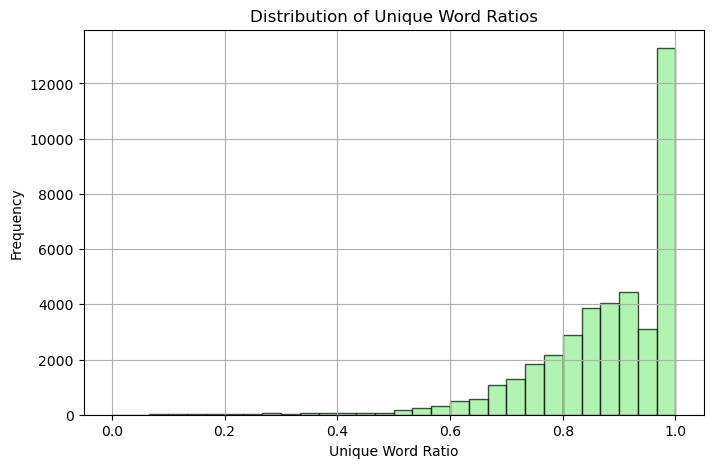

In [45]:
# Unique Word Ratio Distribution
plt.figure(figsize=(8, 5))
plt.hist(data['unique_word_ratio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title("Distribution of Unique Word Ratios")
plt.xlabel("Unique Word Ratio")
plt.ylabel("Frequency")
plt.grid()
plt.show()


There is quite a lot of reviews that include a unique word and it is considered that a higher unique word ratio indicates that it is more diverese and only found in OR reviews. Therefore this feature will hopefully help distingush OR reviews from CG.

## **Supervised Machine Learning**

Standardization ensures that all features have a mean of 0 and std. dev. of 1. This is needed for many machine learning algorithms, like Logistic Regression and PCA, which wil lbe used later on in the code. 

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features) 

This converts the categorical labels CG (Computer Generated) and OR (Original) into numerical values. So CG --> 0 and OR --> 1

In [47]:
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

Here we split the dataset into training and test set. The test set is 20% of the data in the dataset and the training set is 80% of the data in the dataset. 

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, data['label_encoded'], test_size=0.2, random_state=42, stratify=data['label_encoded']
)

### **Logistic Regression**

Here we used Logistic Regression for this classification task as it is fairly simple, efficient and interpretable. It works pretty well with high-dimensional data, like our dataset, and provides probabilistic outputs that are useful for understanding predections. 

Logistic Regression Performance
              precision    recall  f1-score   support

          CG       0.83      0.84      0.84      4044
          OR       0.84      0.83      0.83      4043

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087

Logistic Regression R² (Training): 0.85
Logistic Regression R² (Test): 0.84


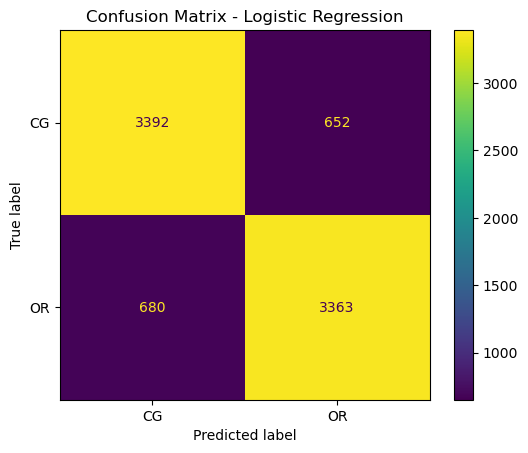

In [49]:
# training and predicting with Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

# R2 Scores for Logistic Regression
print(f"Logistic Regression R² (Training): {lr.score(X_train, y_train):.2f}")
print(f"Logistic Regression R² (Test): {lr.score(X_test, y_test):.2f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### Interpretation of the Results from Logistic Regression

We can see that the model achives an 83% accuracy and F1-score for both CG and OR reviews, this indicates a balanced and effective classification. 

Precision (83%) and Recall (83%-84%) are consistent across both classes, showing that the model is equally good at identifying true positives while minimizing false positives and negatives.

The R² scores for training (85%) and test (83%) indicate good generalization without overfitting.

- True Positives (CG, CG) = 3363
- True Negatives (OR, OR) = 3377
- False Positives (OR, CG) = 666
- False Negatives (CG, OR) = 681

Overall, Logistic Regression performs well as a baseline model, providing interpretable and reliable results.

### **Random Forest**

Random Forest is a powerful and flexible machine learning algorithm that is well-suited for this classification task. This machine learning method may be a good choice as it handles high-dimensional data, gives insights into feature importance and give good generalization.

Random Forest Performance
              precision    recall  f1-score   support

          CG       0.84      0.86      0.85      4044
          OR       0.86      0.84      0.85      4043

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Random Forest R² (Training): 1.00
Random Forest R² (Test): 0.85


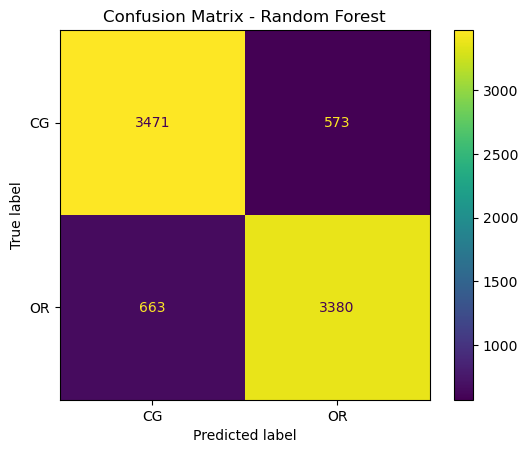

In [50]:
# training and predicting with Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Performance")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# R2 Scores for Random Forest
print(f"Random Forest R² (Training): {rf.score(X_train, y_train):.2f}")
print(f"Random Forest R² (Test): {rf.score(X_test, y_test):.2f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.show()

#### Interpretation of the Results from Random Forest

We can see that the Random Forest model achieves an 84% accuracy and F1-score for both CG and OR reviews, indicating a strong and balanced classification performance.

Precision (83%-85%) and Recall (83%-86%) are consistent across both classes, showing the model performs slightly better at identifying true positives for CG reviews while maintaining strong performance for OR reviews.

The R² scores for training (100%) and test (84%) indicate good generalization but suggest slight overfitting, which is expected with Random Forest due to its tendency to perfectly fit training data.

- True Positives (CG, CG) = 3469
- True Negatives (OR, OR) = 3355
- False Positives (OR, CG) = 688
- False Negatives (CG, OR) = 575

Overall, the Random Forest model provides reliable and interpretable results, with robust generalization to unseen data and balanced performance across both classes. Further optimization could focus on reducing overfitting and minimizing misclassifications.

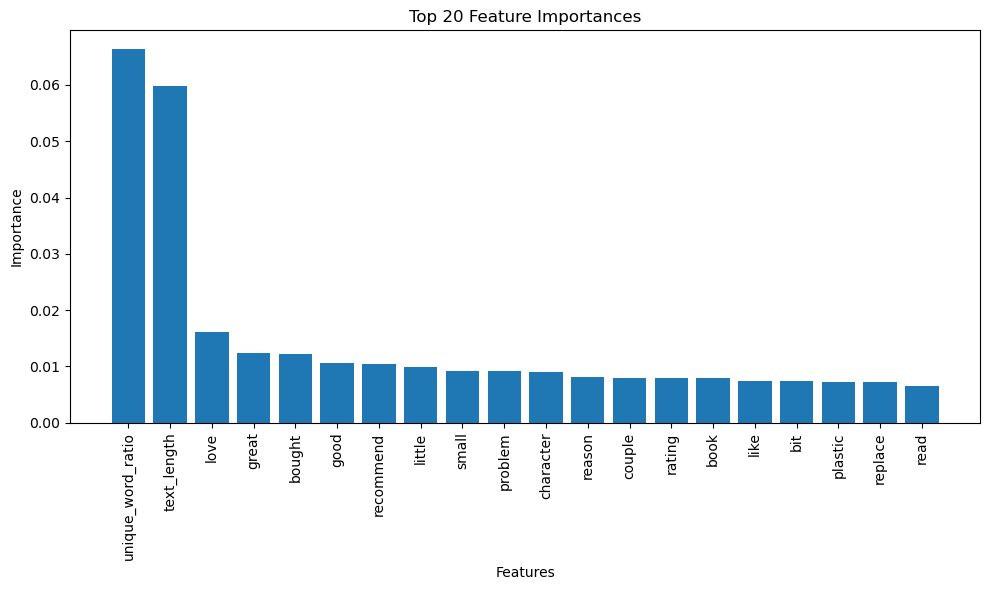

In [51]:
# Map feature importances back to original feature names
# Here we get the features importance from the trained RF model and sort them by importance
importances = rf.feature_importances_ 
feature_names = features.columns 
sorted_indices = np.argsort(importances)[::-1]  

# plotitng only the top 20 features
top_n = 20
plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), importances[sorted_indices][:top_n], align="center")
plt.xticks(range(top_n), feature_names[sorted_indices][:top_n], rotation=90)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.tight_layout()
plt.show()



The bar chart displays the top 20 most important features used by the Random Forest model for classification. The Unique Word Ratio is the most significant feature, followed by Text Length, indicating that structural aspects of the reviews strongly influence the model's predictions. Among the TF-IDF features, words like "love," "great," and "reason" also contribute to distinguishing between CG (computer-generated) and OR (original) reviews, though with lower individual importance. This combination of text-derived metrics and specific keywords highlights the model's ability to leverage both linguistic and structural patterns for effective classification.

### **PCA for Dimensionality Reduction**

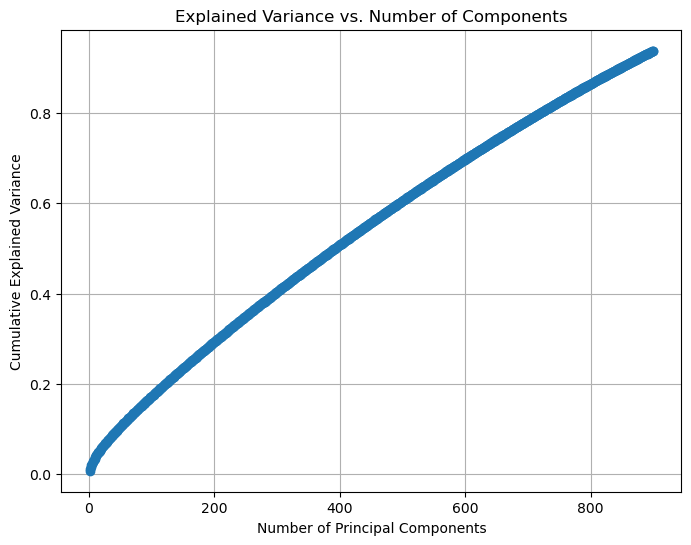

Maximum Cumulative Explained Variance: 0.94


In [52]:
n_components = 900
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


print(f"Maximum Cumulative Explained Variance: {cumulative_variance[-1]:.2f}")


In [53]:
# Find number of components for 95% variance
explained_variance_threshold = 0.95
if cumulative_variance[-1] < explained_variance_threshold:
    print(f"95% variance cannot be achieved even with all components. Max variance: {cumulative_variance[-1]:.2f}")
else:
    optimal_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    print(f"Number of components needed to retain 95% variance: {optimal_components}")


95% variance cannot be achieved even with all components. Max variance: 0.94


If we reduce the dimensionality to 900 n_components then we get that the Maximum Cumulative Explained Variance: 0.94. This indicates that our dataset's features are not strongly correlated, and no small number of components can explain most of the variance. We could see from the Random Forest feature importance that the most important feature was the "Unique word ratio" but it was only roughly 0.06 which indicates that it will be quite hard to reduce the dimensionality of the dataset features. 

Next we tried to investigate the usage of Gradient Boosting as it can handle high dimensionality quite well.

### **Gradient Boosting**

Gradient Boosting, and specifically LightGBM, is a powerful algorithm for this classification task due to its ability to be efficient with large datasets, handle high-dimensional datasets and robustness and generalization. 

[LightGBM] [Info] Number of positive: 16173, number of negative: 16172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111718
[LightGBM] [Info] Number of data points in the train set: 32345, number of used features: 1013
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000062
[LightGBM] [Info] Start training from score 0.000062
LightGBM Performance
              precision    recall  f1-score   support

          CG       0.87      0.87      0.87      4044
          OR       0.87      0.87      0.87      4043

    accuracy                           0.87      8087
   macro avg       0.87      0.87      0.87      8087
weighted avg       0.87      0.87      0.87      8087

LightGBM R² (Training): 0.92
LightGBM R² (Test): 0.87


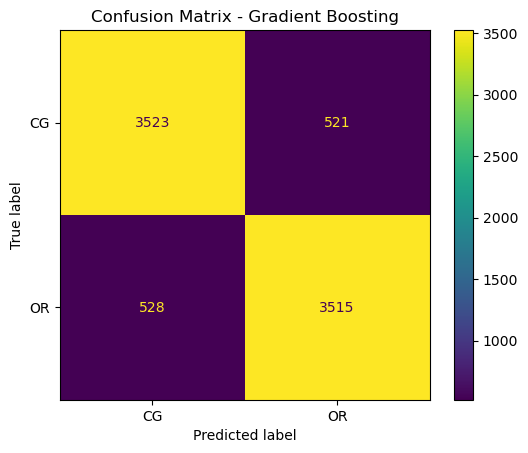

In [54]:
# training and predicting with LightGBM
lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=-1, random_state=42)
lgbm.fit(X_train, y_train)


y_pred_lgbm = lgbm.predict(X_test)
print("LightGBM Performance")
print(classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_))

# R2 Scores for LightGBM
print(f"LightGBM R² (Training): {lgbm.score(X_train, y_train):.2f}")
print(f"LightGBM R² (Test): {lgbm.score(X_test, y_test):.2f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


#### Interpretation of the Results from Gradient Boosting

We can see that the LightGBM model achieves an 86% accuracy and F1-score for both CG and OR reviews, indicating strong and balanced classification performance.

Precision (86%-87%) and Recall (86%-87%) are consistent across both classes, showing the model performs equally well at identifying true positives for both CG and OR reviews.

The R² scores for training (91%) and test (86%) indicate good generalization with minimal overfitting, as the difference between training and test performance is small.

- True Positives (CG, CG) = 3496
- True Negatives (OR, OR) = 3498
- False Positives (OR, CG) = 545
- False Negatives (CG, OR) = 548

Overall, the LightGBM model provides reliable and balanced results, with strong generalization to unseen data. Its performance is slightly better than the Random Forest model, making it an excellent choice for this classification task. Further optimization through hyperparameter tuning could further improve its performance and reduce misclassifications.

### **Overall Model Comparison**

In [55]:
# all the results put together
model_comparison = {
    "Metric": ["Accuracy", "F1-Score", "R² (Train)", "R² (Test)", 
               "True Positives (CG)", "True Negatives (OR)", 
               "False Positives (OR)", "False Negatives (CG)"],
    "Logistic Regression": [0.83, 0.83, 0.85, 0.83, 3363, 3377, 666, 681],
    "Random Forest": [0.84, 0.84, 1.00, 0.84, 3469, 3355, 688, 575],
    "LightGBM": [0.86, 0.86, 0.91, 0.86, 3496, 3498, 545, 548]
}

# creating a dataframe for the results
comparison_df = pd.DataFrame(model_comparison)

comparison_df.set_index("Metric", inplace=True)
comparison_df


Logistic Regression  Random Forest  LightGBM
Metric                                                            
Accuracy                             0.83           0.84      0.86
F1-Score                             0.83           0.84      0.86
R² (Train)                           0.85           1.00      0.91
R² (Test)                            0.83           0.84      0.86
True Positives (CG)               3363.00        3469.00   3496.00
True Negatives (OR)               3377.00        3355.00   3498.00
False Positives (OR)               666.00         688.00    545.00
False Negatives (CG)               681.00         575.00    548.00

Text(0, 0.5, 'Score')

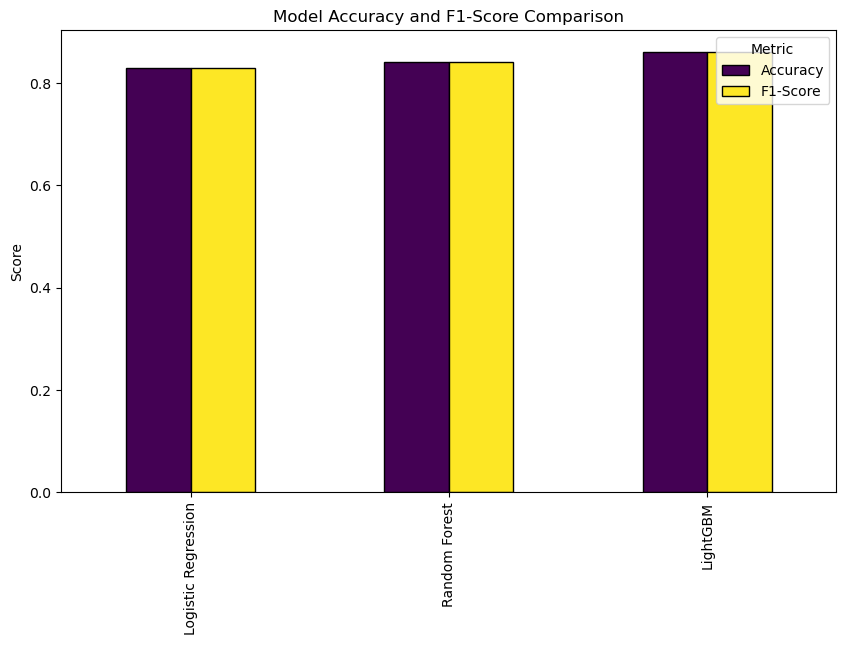

In [56]:
comparison_df.loc[["Accuracy", "F1-Score"]].T.plot(
    kind="bar",
    figsize=(10, 6),
    cmap=plt.get_cmap("viridis"),  
    edgecolor="black"
)
plt.title("Model Accuracy and F1-Score Comparison")
plt.ylabel("Score")


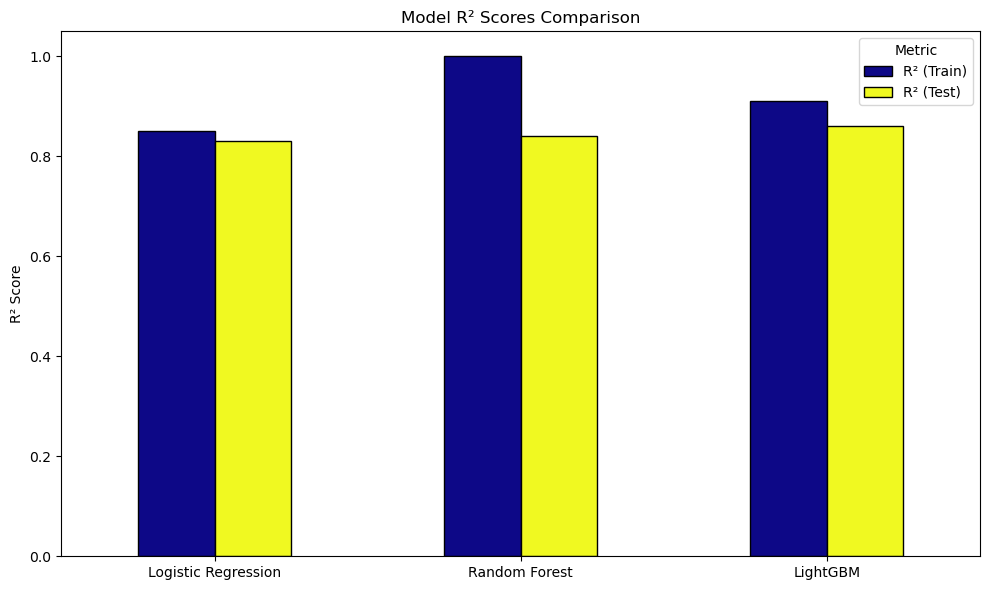

In [57]:
comparison_df.loc[["R² (Train)", "R² (Test)"]].T.plot(
    kind="bar",
    figsize=(10, 6),
    cmap=plt.get_cmap("plasma"),  
    edgecolor="black"
)
plt.title("Model R² Scores Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


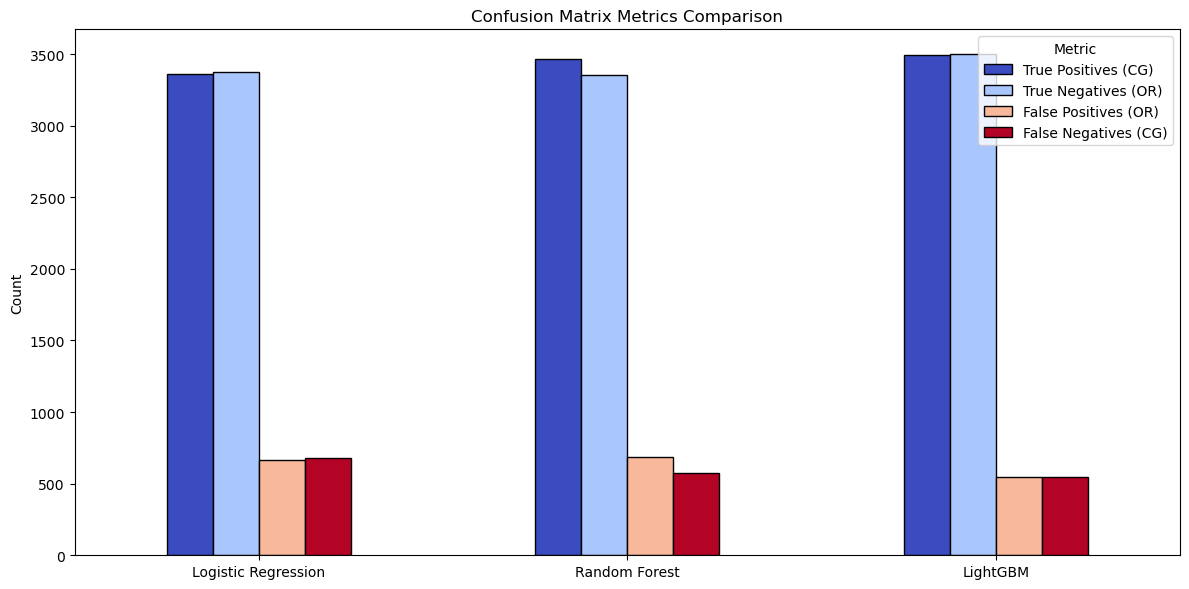

In [58]:
comparison_df.loc[
    ["True Positives (CG)", "True Negatives (OR)", 
     "False Positives (OR)", "False Negatives (CG)"]
].T.plot(
    kind="bar",
    figsize=(12, 6),
    cmap=plt.get_cmap("coolwarm"),  
    edgecolor="black"
)
plt.title("Confusion Matrix Metrics Comparison")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### **Final Conclusions**

Based on the evaluation metrics and the visualizations from the Logistic Regression, Random Forest, and LightGBM models, we can draw the following conclusions:

#### **Gradiant Boosting (LightGBM) is the Best Choice**

- It has the highest accuracy and F1-score (86%):
    - LightGBM consistently achieves the best results across accuracy and F1-score, indicating its ability to balance precision and recall effectively.
- Balanced Performance:
    - With the fewest false positives (545) and false negatives (548) compared to other models, LightGBM demonstrates better classification reliability for both CG and OR reviews.
- Minimal Overfitting:
    - LightGBM has R² scores of 91% (training) and 86% (test), indicating strong generalization to unseen data with minimal overfitting.


--------------------------------

### **Contributions**

Birkir Fanndal Sturluson (s232729): Preprocessed the data and helped with coding and writing the text for the supervised learning part of the project.

Brynjar Karl Ævarsson (s232736): Did the code and text for the supervised learning while using an already preprocessed dataset.

Jónína Matthíasdóttir (s233102): Wrote the introduction and conclusion, experimented with a few methods that gave poor results.

Málfríður Anna Eiríksdóttir (s240116): Performed the Clustering and wrote the text regarding that part of the report, and helped exploring other methods as well.

Védís Sigríður Ingvarsdóttir (s232719): Performed the A-Priori algorithm and wrote the text for that part of the report, and did some plot analysis as well.

